In [90]:
import requests
import json
import time
import random
import logging
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import pandas as pd

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("data_ingestion.log"),
                        logging.StreamHandler()
                    ])

APP_TOKEN = ''

def get_last_6_months_date():
    return (datetime.now() - timedelta(days=24*30)).strftime('%Y-%m-%dT%H:%M:%S')

def fetch_data_from_api(offset=0, limit=1000, retries=5):
    six_months_ago = get_last_6_months_date()
    url = (
        f"https://data.cityofnewyork.us/resource/erm2-nwe9.json"
        f"?$limit={limit}"
        f"&$offset={offset}"
        f"&$where=created_date >= '{six_months_ago}' AND incident_zip IN('10467', '10470')"
        f"&$order=unique_key"
    )
    headers = {
        "X-App-Token": APP_TOKEN
    }

    for i in range(retries):
        try:
            logging.info(f"Fetching data from offset: {offset}")
            response = requests.get(url, headers=headers, timeout=60)
            logging.info(f"Status code: {response.status_code}")
            if response.status_code == 200:
                data = response.json()
                logging.info(f"Received {len(data)} records")
                return data if data else []
            else:
                logging.error(f"Error fetching data: {response.status_code}")
                return []
        except requests.Timeout:
            wait_time = 2 ** i + random.random()
            logging.warning(f"Request timed out, retrying in {wait_time:.2f} seconds...")
            time.sleep(wait_time)
        except requests.RequestException as e:
            logging.error(f"Request failed: {e}")
            break
    return []

def fetch_data_in_parallel(offsets, limit=1000):
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda offset: fetch_data_from_api(offset, limit), offsets))
    return results

def flatten_data(record):
    human_address_str = record.get('location', {}).get('human_address', '')
    if isinstance(human_address_str, str) and human_address_str:
        try:
            human_address = json.loads(human_address_str)
        except json.JSONDecodeError:
            human_address = {}
    else:
        human_address = {}

    flattened_record = {
        'unique_key': record.get('unique_key'),
        'created_date': record.get('created_date'),
        'closed_date': record.get('closed_date'),
        'agency': record.get('agency'),
        'complaint_type': record.get('complaint_type'),
        'descriptor': record.get('descriptor'),
        'incident_zip': record.get('incident_zip'),
        'city': record.get('city'),
        'borough': record.get('borough'),
        'latitude': record.get('latitude'),
        'longitude': record.get('longitude')
    }
    return flattened_record

def main():
    offset = 0
    limit = 1000
    all_flattened_data = []

    while True:
        offsets = [offset + i * limit for i in range(5)]
        api_data_batches = fetch_data_in_parallel(offsets, limit=limit)

        for api_data in api_data_batches:
            if not api_data:
                logging.info("No more data to fetch or request failed.")
                continue

            flattened_data = [flatten_data(record) for record in api_data]
            all_flattened_data.extend(flattened_data)
        
        if all([len(batch) == 0 for batch in api_data_batches]):
            logging.info("All data batches are empty. Stopping further requests.")
            break
        
        offset += limit * 5
        time.sleep(random.uniform(0.5, 2))  # Avoid overwhelming the API

    df = pd.DataFrame(all_flattened_data)
    return df

if __name__ == "__main__":
    try:
        df = main()
        logging.info(f"Data fetched. DataFrame contains {len(df)} rows.")
        print(df.head())
    except KeyboardInterrupt:
        logging.info("Data fetching process interrupted by user.")
    except Exception as e:
        logging.exception(f"An unexpected error occurred: {e}")
    finally:
        logging.info("Data fetching process terminated.")


2025-06-03 13:00:17,505 - INFO - Fetching data from offset: 0
2025-06-03 13:00:17,506 - INFO - Fetching data from offset: 1000
2025-06-03 13:00:17,506 - INFO - Fetching data from offset: 2000
2025-06-03 13:00:17,506 - INFO - Fetching data from offset: 3000
2025-06-03 13:00:17,506 - INFO - Fetching data from offset: 4000
2025-06-03 13:00:19,081 - INFO - Status code: 200
2025-06-03 13:00:19,122 - INFO - Received 1000 records
2025-06-03 13:00:19,410 - INFO - Status code: 200
2025-06-03 13:00:19,456 - INFO - Received 1000 records
2025-06-03 13:00:31,856 - INFO - Status code: 200
2025-06-03 13:00:31,881 - INFO - Received 1000 records
2025-06-03 13:01:17,765 - WARNING - Request timed out, retrying in 1.61 seconds...
2025-06-03 13:01:17,776 - WARNING - Request timed out, retrying in 1.71 seconds...
2025-06-03 13:01:19,390 - INFO - Fetching data from offset: 2000
2025-06-03 13:01:19,497 - INFO - Fetching data from offset: 0
2025-06-03 13:01:23,515 - INFO - Status code: 200
2025-06-03 13:01:23,

  unique_key             created_date              closed_date agency  \
0   57892229  2023-06-14T16:35:18.000  2023-06-15T01:07:56.000   NYPD   
1   57892282  2023-06-14T13:39:36.000  2023-06-14T14:02:21.000   NYPD   
2   57892939  2023-06-14T17:23:37.000  2023-06-15T10:33:40.000   NYPD   
3   57892973  2023-06-14T21:07:56.000  2023-06-15T03:10:53.000   NYPD   
4   57893243  2023-06-14T13:08:16.000  2023-07-06T05:03:00.000    HPD   

        complaint_type        descriptor incident_zip   city borough  \
0     Blocked Driveway         No Access        10470  BRONX   BRONX   
1     Blocked Driveway    Partial Access        10467  BRONX   BRONX   
2      Illegal Parking   Blocked Hydrant        10467  BRONX   BRONX   
3  Noise - Residential  Banging/Pounding        10467  BRONX   BRONX   
4          DOOR/WINDOW              DOOR        10467  BRONX   BRONX   

             latitude           longitude  
0    40.8992944575005  -73.86749951364646  
1  40.868574991645396  -73.8643717663779

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120535 entries, 0 to 120534
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   unique_key      120535 non-null  object
 1   created_date    120535 non-null  object
 2   closed_date     118652 non-null  object
 3   agency          120535 non-null  object
 4   complaint_type  120535 non-null  object
 5   descriptor      120323 non-null  object
 6   incident_zip    120535 non-null  object
 7   city            117220 non-null  object
 8   borough         120535 non-null  object
 9   latitude        119980 non-null  object
 10  longitude       119980 non-null  object
dtypes: object(11)
memory usage: 10.1+ MB


In [92]:
import pandas as pd

# Convert date columns to datetime
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

# Convert latitude and longitude to numeric
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop rows with missing lat/lon
df = df.dropna(subset=['latitude', 'longitude'])

# Confirm types and nulls
print(df.dtypes)
print(df.isnull().sum())


unique_key                object
created_date      datetime64[ns]
closed_date       datetime64[ns]
agency                    object
complaint_type            object
descriptor                object
incident_zip              object
city                      object
borough                   object
latitude                 float64
longitude                float64
dtype: object
unique_key           0
created_date         0
closed_date       1861
agency               0
complaint_type       0
descriptor         212
incident_zip         0
city              3049
borough              0
latitude             0
longitude            0
dtype: int64


In [93]:
import pandas as pd
from shapely.geometry import Point, Polygon

# Define your quadrilateral using (longitude, latitude) pairs
polygon = Polygon([
    (-73.872168, 40.878765),
    (-73.871046, 40.878558),
    (-73.863889, 40.895472),  # 40°53'43.7"N 73°51'50.0"W in decimal
    (-73.863040, 40.895186)
])

# Function to check if a point is within the polygon
def is_within_polygon(lat, lon, poly):
    point = Point(lon, lat)  # Note: (lon, lat)
    return poly.contains(point)

# Apply the filter to your DataFrame
df['in_polygon'] = df.apply(
    lambda row: is_within_polygon(row['latitude'], row['longitude'], polygon),
    axis=1
)

# Get only rows inside the polygon
df_filtered = df[df['in_polygon']].drop(columns='in_polygon')

# Output result
print(df_filtered)
print(f"\nTotal complaints within polygon: {len(df_filtered)}")


       unique_key        created_date         closed_date agency  \
112      57906667 2023-06-15 02:34:16 2023-06-15 06:12:34   NYPD   
270      57916229 2023-06-16 15:10:27 2023-06-21 18:00:39    HPD   
273      57916323 2023-06-16 11:32:40 2023-06-20 13:41:24    DPR   
418      57926398 2023-06-17 10:07:11 2023-06-17 12:01:44   NYPD   
627      57938978 2023-06-19 00:26:43 2023-06-19 03:13:48   NYPD   
...           ...                 ...                 ...    ...   
120370   65125425 2025-06-01 16:23:06 2025-06-01 16:23:06    DOB   
120386   65126434 2025-06-01 15:49:23                 NaT    HPD   
120394   65126590 2025-06-01 15:43:47 2025-06-01 15:43:47    DOB   
120484   65132025 2025-06-01 08:42:32 2025-06-01 09:24:35   NYPD   
120496   65132437 2025-06-01 16:26:07 2025-06-01 16:26:07    DOB   

             complaint_type                               descriptor  \
112         Illegal Parking             Commercial Overnight Parking   
270          HEAT/HOT WATER            

In [94]:
print(df_filtered.info())
print(df_filtered.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 112 to 120496
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unique_key      899 non-null    object        
 1   created_date    899 non-null    datetime64[ns]
 2   closed_date     878 non-null    datetime64[ns]
 3   agency          899 non-null    object        
 4   complaint_type  899 non-null    object        
 5   descriptor      898 non-null    object        
 6   incident_zip    899 non-null    object        
 7   city            899 non-null    object        
 8   borough         899 non-null    object        
 9   latitude        899 non-null    float64       
 10  longitude       899 non-null    float64       
dtypes: datetime64[ns](2), float64(2), object(7)
memory usage: 84.3+ KB
None
       unique_key         created_date                    closed_date agency  \
count         899                  899                        

In [95]:
print("Basic Info:")
print(df_filtered.info())

print("\nMissing Values:")
print(df_filtered.isnull().sum())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 112 to 120496
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unique_key      899 non-null    object        
 1   created_date    899 non-null    datetime64[ns]
 2   closed_date     878 non-null    datetime64[ns]
 3   agency          899 non-null    object        
 4   complaint_type  899 non-null    object        
 5   descriptor      898 non-null    object        
 6   incident_zip    899 non-null    object        
 7   city            899 non-null    object        
 8   borough         899 non-null    object        
 9   latitude        899 non-null    float64       
 10  longitude       899 non-null    float64       
dtypes: datetime64[ns](2), float64(2), object(7)
memory usage: 84.3+ KB
None

Missing Values:
unique_key         0
created_date       0
closed_date       21
agency             0
complaint_type     0
descript

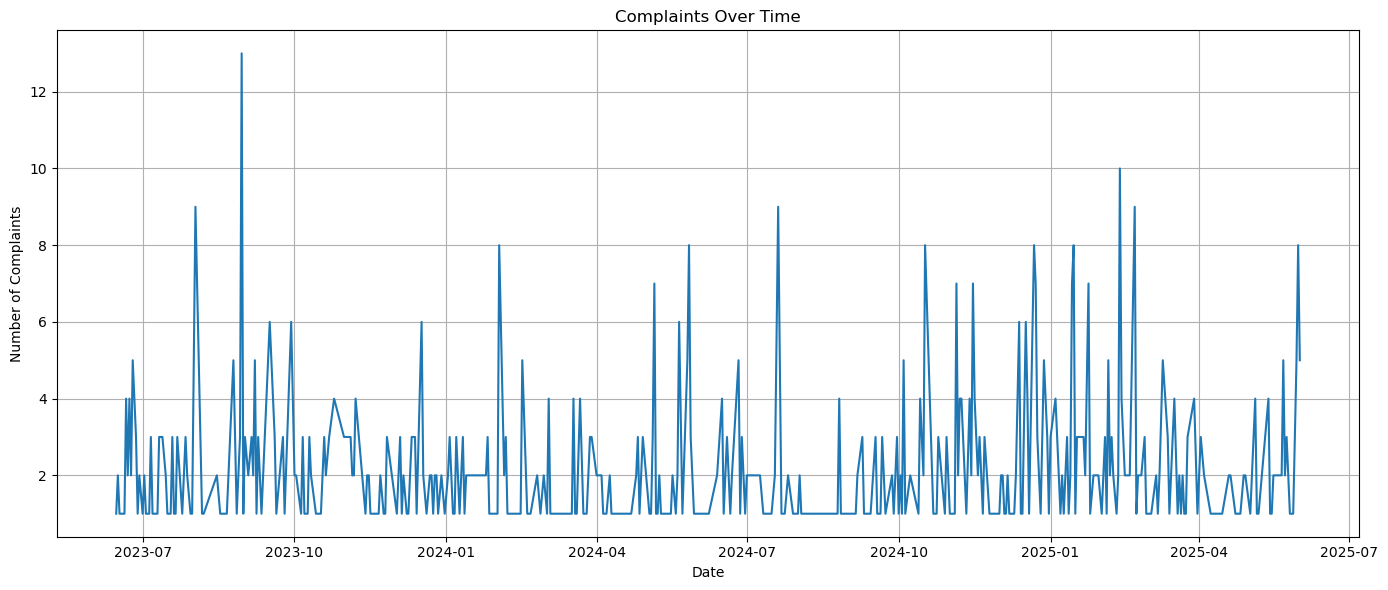

In [96]:
import matplotlib.pyplot as plt

df_filtered['created_date_only'] = df_filtered['created_date'].dt.date
complaints_per_day = df_filtered.groupby('created_date_only').size()

plt.figure(figsize=(14, 6))
complaints_per_day.plot()
plt.title("Complaints Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Complaints")
plt.grid(True)
plt.tight_layout()
plt.show()


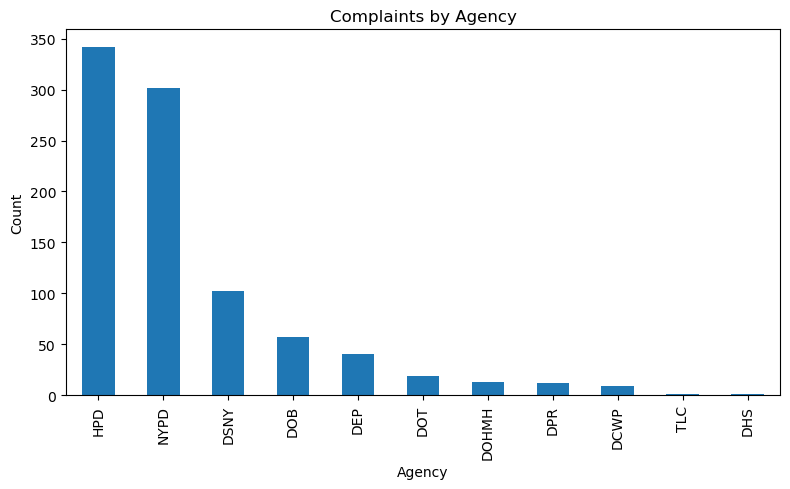

In [97]:
agency_counts = df_filtered['agency'].value_counts()

plt.figure(figsize=(8, 5))
agency_counts.plot(kind='bar')
plt.title("Complaints by Agency")
plt.xlabel("Agency")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


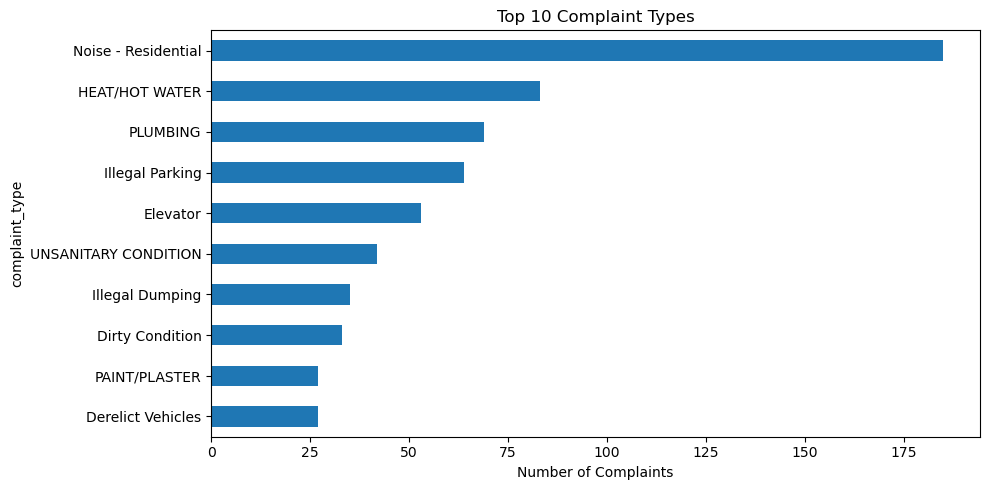

In [98]:
top_complaints = df_filtered['complaint_type'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_complaints.plot(kind='barh')
plt.title("Top 10 Complaint Types")
plt.xlabel("Number of Complaints")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


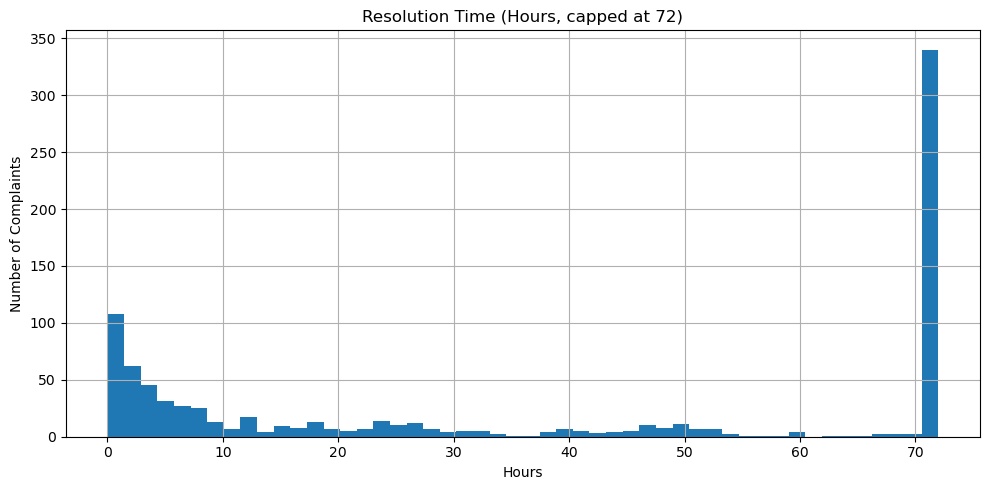


Avg resolution time: 327.01 hours
Median resolution time: 30.55 hours


In [99]:
df_filtered['resolution_time'] = (df_filtered['closed_date'] - df_filtered['created_date']).dt.total_seconds() / 3600  # hours

plt.figure(figsize=(10, 5))
df_filtered['resolution_time'].dropna().clip(upper=72).hist(bins=50)
plt.title("Resolution Time (Hours, capped at 72)")
plt.xlabel("Hours")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

print(f"\nAvg resolution time: {df_filtered['resolution_time'].mean():.2f} hours")
print(f"Median resolution time: {df_filtered['resolution_time'].median():.2f} hours")


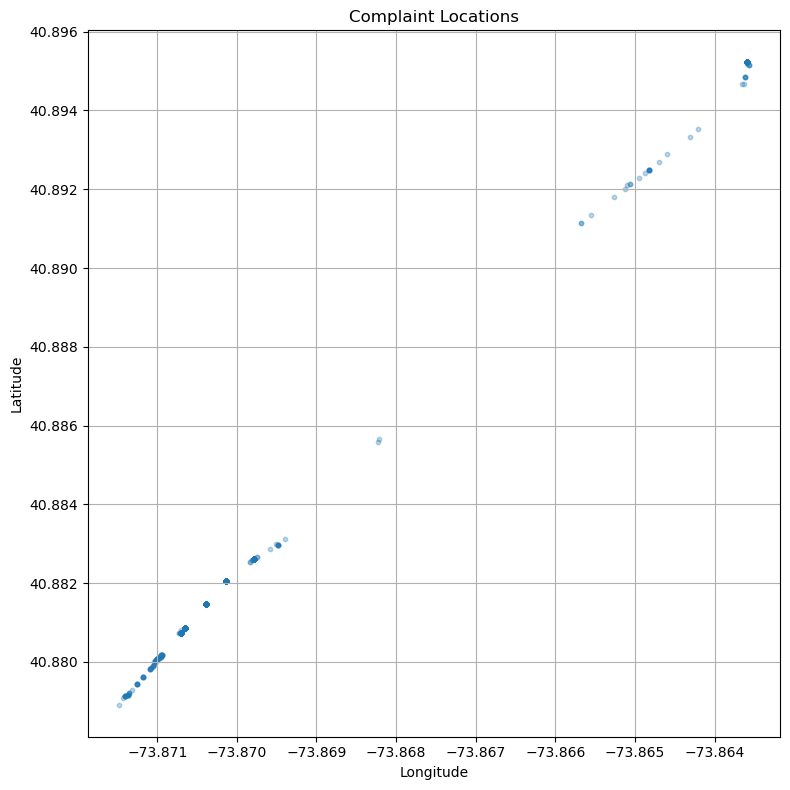

In [100]:
plt.figure(figsize=(8, 8))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], alpha=0.3, s=10)
plt.title("Complaint Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


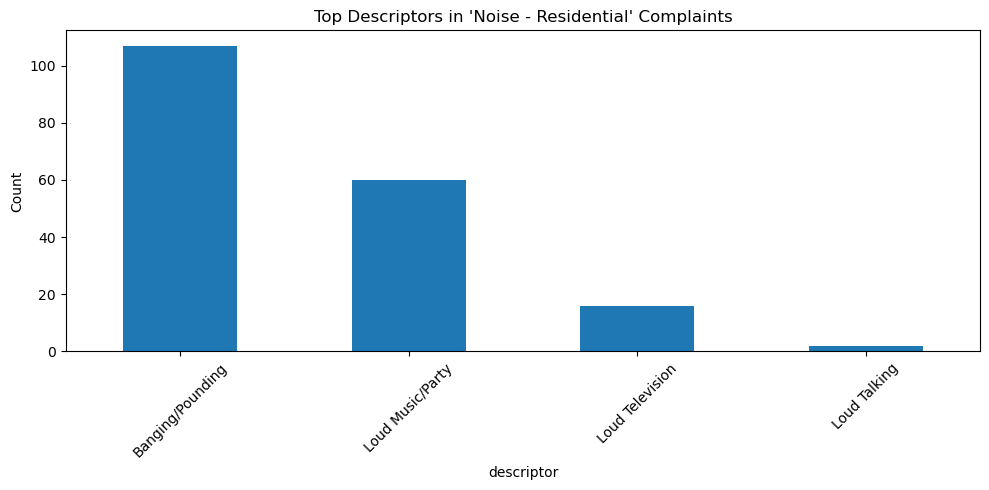

In [101]:
top_complaint = df_filtered['complaint_type'].value_counts().idxmax()
top_df = df_filtered[df_filtered['complaint_type'] == top_complaint]
top_descriptors = top_df['descriptor'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_descriptors.plot(kind='bar')
plt.title(f"Top Descriptors in '{top_complaint}' Complaints")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [102]:
complaints_of_interest = ['Illegal Dumping', 'UNSANITARY CONDITION', 'Dirty Condition', 'Derelict Vehicles']

df_filtered = df_filtered[df_filtered['complaint_type'].isin(complaints_of_interest)].copy()

print(f"Number of complaints after filtering: {len(df_filtered)}")


Number of complaints after filtering: 137


In [103]:
output_path = '/Users/danielbrown/Desktop/filtered_complaints.csv'
df_filtered.to_csv(output_path, index=False)
print(f"Exported {len(df_filtered)} complaints to: {output_path}")


Exported 137 complaints to: /Users/danielbrown/Desktop/filtered_complaints.csv
